In [1]:
#Import Libraries/Packages
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.10.0
Num GPUs Available:  0


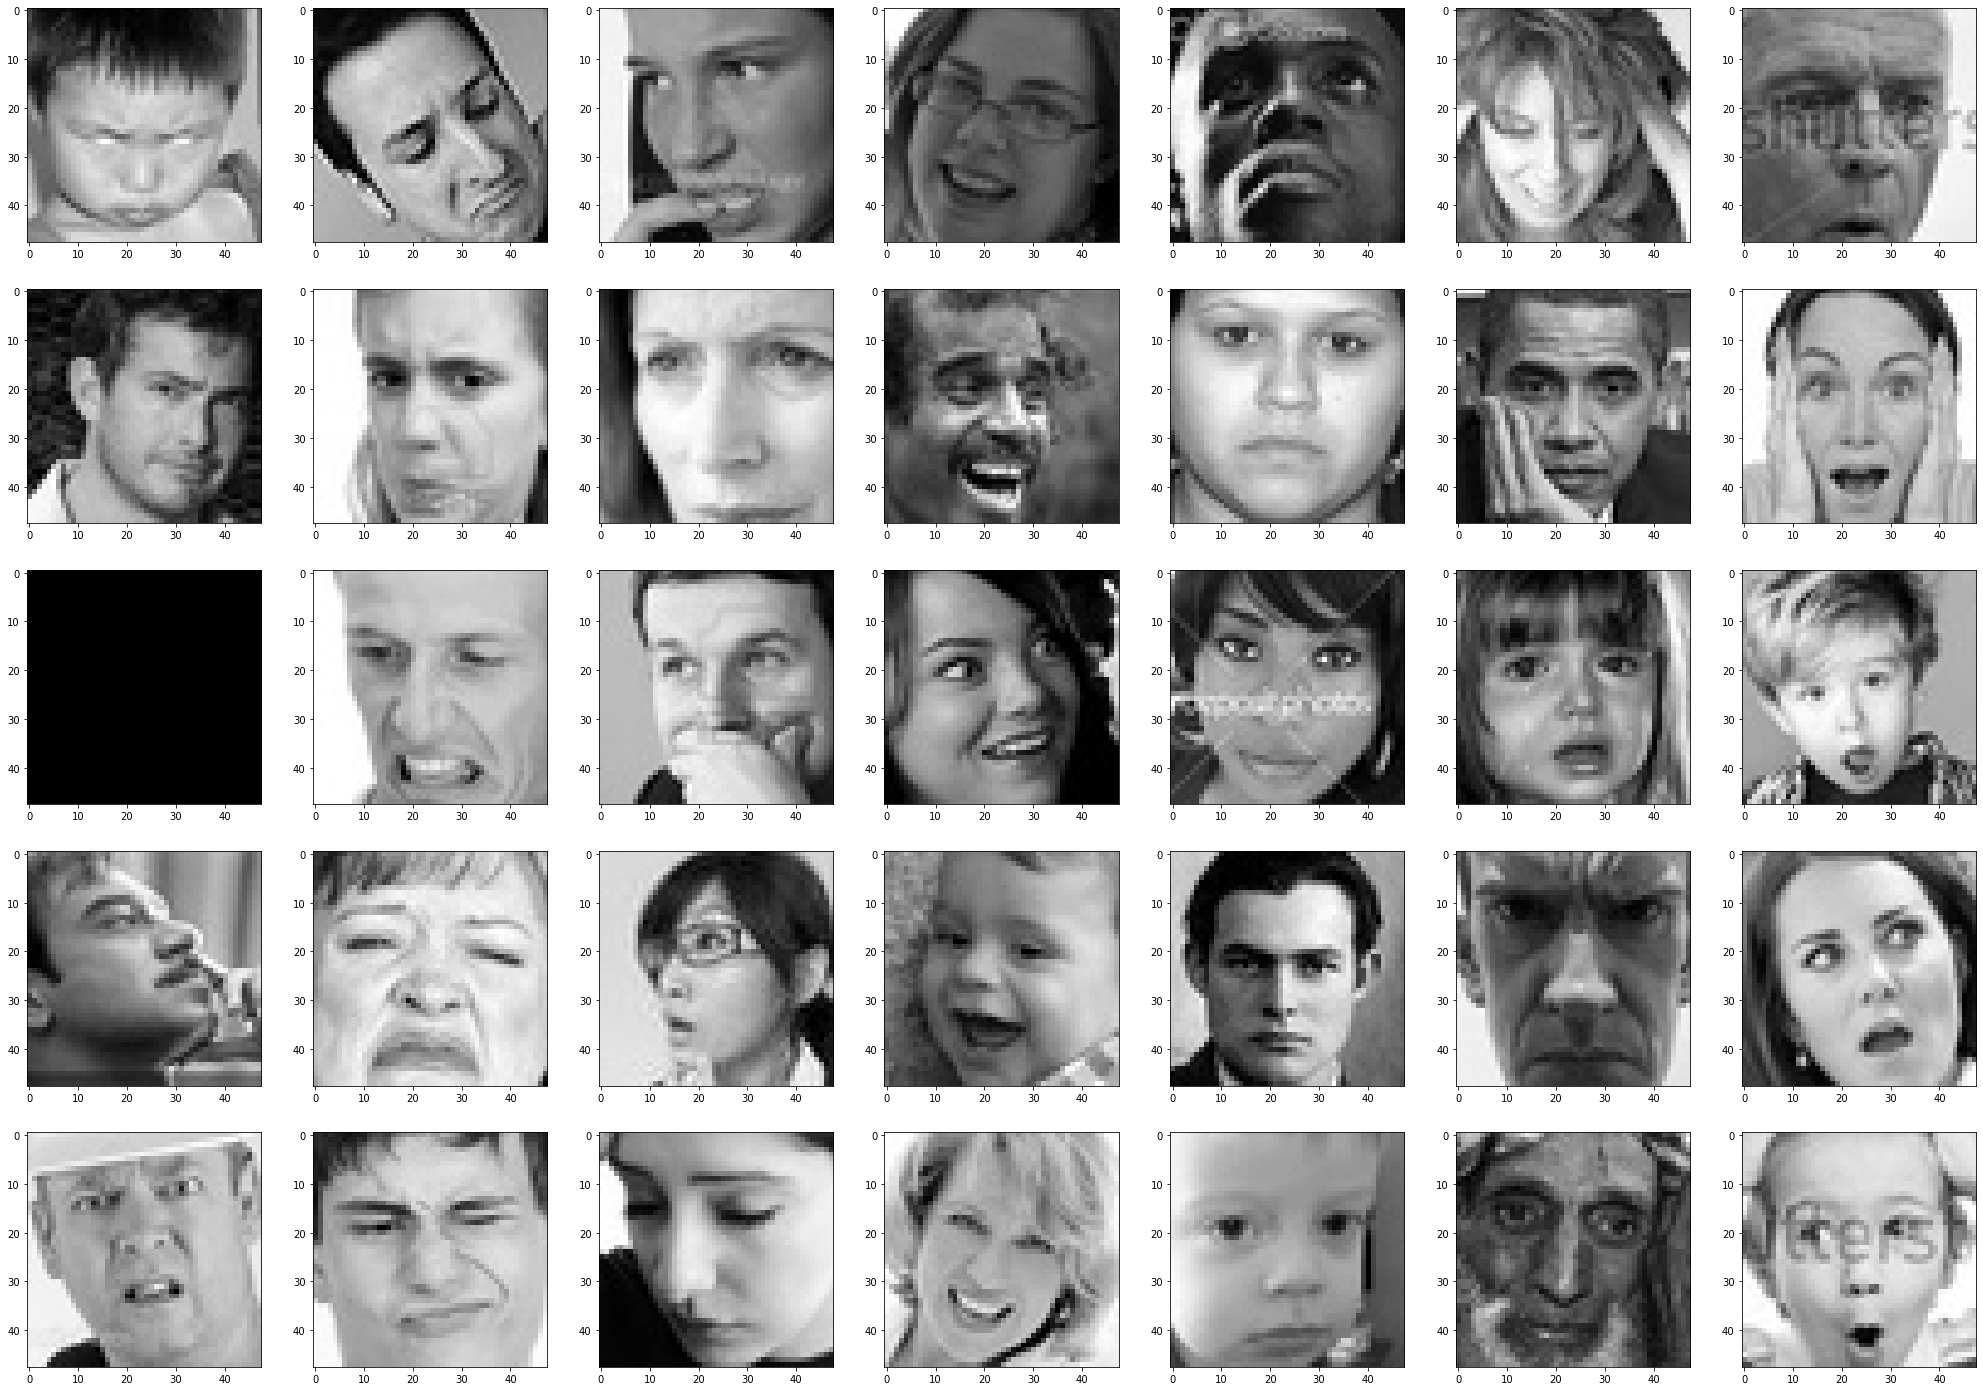

In [3]:
# Data Visualization
from skimage.io import imread
train_dir = "G:\\Task 10 LGM\\train\\"
test_dir = "G:\\Task 10 LGM\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

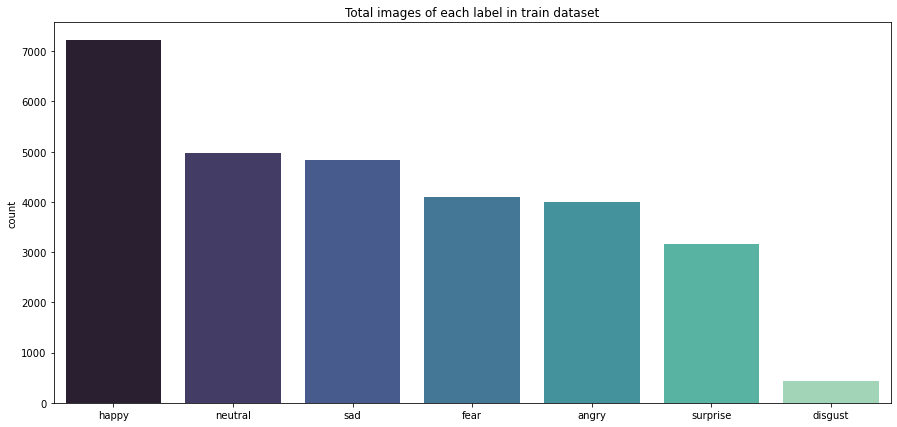

In [4]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


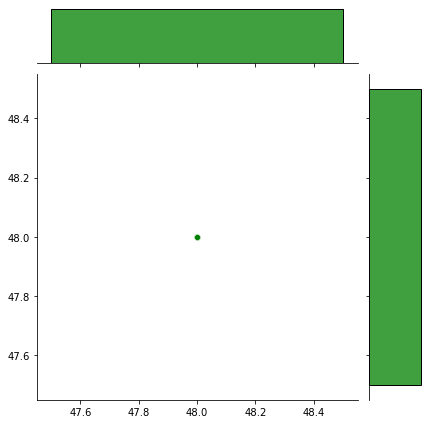

In [5]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='g')
plt.show()

In [6]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [8]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 1368s 3s/step - loss: 1.8775 - accuracy: 0.2294 - val_loss: 2.5142 - val_accuracy: 0.1775
Epoch 2/20
448/448 [==============================] - 1460s 3s/step - loss: 1.8017 - accuracy: 0.2463 - val_loss: 1.8049 - val_accuracy: 0.2725
Epoch 3/20
448/448 [==============================] - 1496s 3s/step - loss: 1.7865 - accuracy: 0.2594 - val_loss: 1.7868 - val_accuracy: 0.2796
Epoch 4/20
448/448 [==============================] - 1511s 3s/step - loss: 1.7718 - accuracy: 0.2664 - val_loss: 1.6877 - val_accuracy: 0.3209
Epoch 5/20
448/448 [==============================] - 1487s 3s/step - loss: 1.7595 - accuracy: 0.2787 - val_loss: 1.6788 - val_accuracy: 0.3312
Epoch 6/20
448/448 [==============================] - 1707s 4s/step - loss: 1.7311 - accuracy: 0.2931 - val_loss: 1.7020 - val_accuracy: 0.3365
Epoch 7/20
448/448 [==============================] - 3437s 8s/step - loss: 1.7004 - accuracy: 0.3158 - val_loss: 1.6323 - val_accuracy:

In [11]:
model.save("model.h5") 

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 67s 585ms/step - loss: 1.2141 - accuracy: 0.5301
validation accuracy : 53.009194135665894%
validation loss : 1.2141430377960205


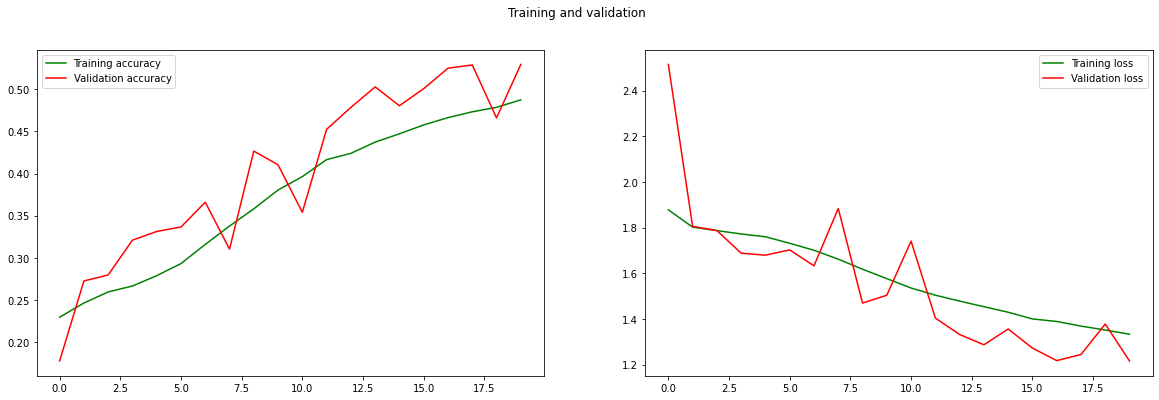

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 69s 596ms/step


C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.41      0.47      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.40      0.10      0.16      1024
       happy       0.71      0.84      0.77      1774
     neutral       0.44      0.64      0.52      1233
         sad       0.50      0.25      0.33      1247
    surprise       0.51      0.80      0.62       831

    accuracy                           0.53      7178
   macro avg       0.42      0.44      0.41      7178
weighted avg       0.51      0.53      0.49      7178





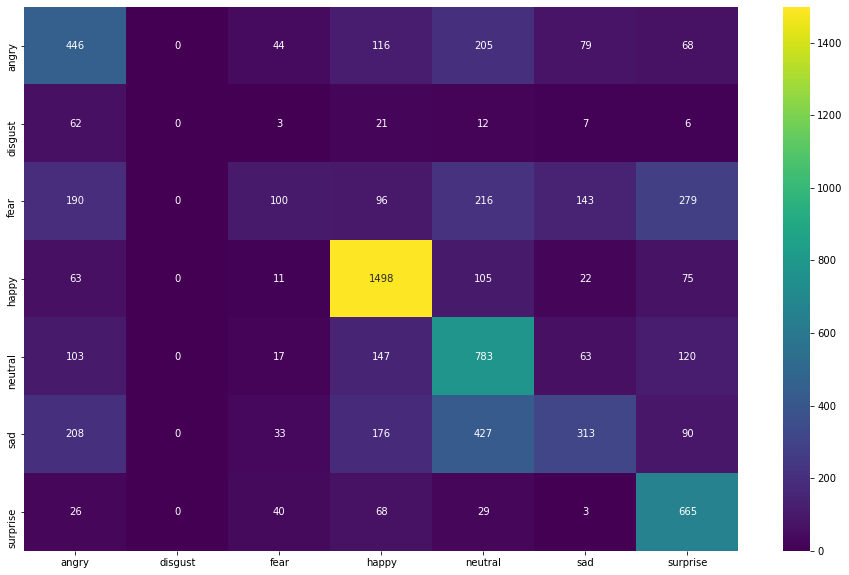

In [14]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

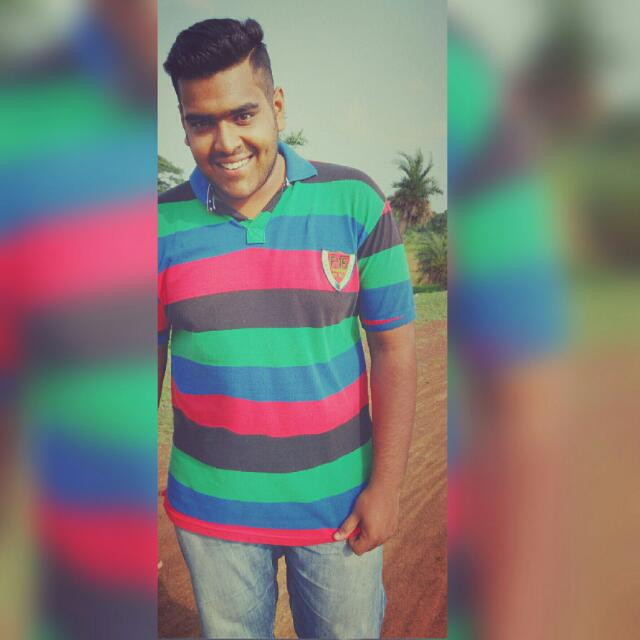

In [31]:
# Testing our model with new image
image = cv2.imread("G:\\Task 10 LGM\\happy.jpg")
from IPython.display import Image
Image(filename='G:\\Task 10 LGM\\happy.jpg')

In [32]:
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model

model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 1s 920ms/step
  Angry   prediction rate is   0.17%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.06%
   Sad    prediction rate is   0.20%
 Surprise prediction rate is   0.38%
 Neutral  prediction rate is   0.15%


 The system considers this expression to be: Surprise


In [33]:
if (label=='Angry'):
    path="G:\\Task 10 LGM\\angry"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='G:\\Task 10 LGM\\angry\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="G:\\Task 10 LGM\\disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='G:\\Task 10 LGM\\disgust\\'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="G:\\Task 10 LGM\\happy1\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='G:\\Task 10 LGM\\happy1\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="G:\\Task 10 LGM\\sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='G:\\Task 10 LGM\\sad\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="G:\\Task 10 LGM\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='G:\\Task 10 LGM\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="G:\\Task 10 LGM\\neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='G:\\Task 10 LGM\\neutral\\'+ d,autoplay=True)
    display(audio)

Now Playing: neutral.mp3
